## Imports

In [1]:
# pip install --upgrade scikit-learn


In [2]:
import time
from IPython.display import clear_output
import numpy    as np
import pandas   as pd
import seaborn  as sb
import matplotlib.pyplot as plt

import sklearn
from sklearn import pipeline      # Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler # OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn import compose
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn import metrics         # accuracy_score, balanced_accuracy_score, plot_confusion_matrix
from sklearn import set_config

set_config(display='diagram') # Useful for display the pipeline

print("Pandas  ", pd.__version__)
print("Sklearn ", sklearn.__version__) # Try to use 0.24

Pandas   1.4.1
Sklearn  1.0.2


## Get the dataset
- **CLOUD = True**: Download dataset from Kaggle. Necesary for cloud enviroments like COLAB. **Specify your [kaggle credentials](https://www.kaggle.com/docs/api)**.
- **CLOUD = False**: Get the dataset from your local machine. **Specify the data path**.

In [3]:
DATA_PATH = "./titanic/"

## Load data

In [4]:
df      = pd.read_csv(DATA_PATH + "train.csv", index_col='PassengerId')
df_test = pd.read_csv(DATA_PATH + "test.csv",  index_col='PassengerId')

print("Train DataFrame:", df.shape)
print("Test DataFrame: ", df_test.shape)

Train DataFrame: (891, 11)
Test DataFrame:  (418, 10)


In [5]:
df.dtypes

Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [6]:
df.sample(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
820,0,3,"Skoog, Master. Karl Thorsten",male,10.0,3,2,347088,27.9000,NaN,S
196,1,1,"Lurette, Miss. Elise",female,58.0,0,0,PC 17569,146.5208,B80,C
320,1,1,"Spedden, Mrs. Frederic Oakley (Margaretta Corn...",female,40.0,1,1,16966,134.5000,E34,C
64,0,3,"Skoog, Master. Harald",male,4.0,3,2,347088,27.9000,NaN,S
739,0,3,"Ivanoff, Mr. Kanio",male,NaN,0,0,349201,7.8958,NaN,S
575,0,3,"Rush, Mr. Alfred George John",male,16.0,0,0,A/4. 20589,8.0500,NaN,S
423,0,3,"Zimmerman, Mr. Leo",male,29.0,0,0,315082,7.8750,NaN,S
217,1,3,"Honkanen, Miss. Eliina",female,27.0,0,0,STON/O2. 3101283,7.9250,NaN,S
147,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S


In [7]:
df_test.sample(10)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1119,3,"McNeill, Miss. Bridget",female,NaN,0,0,370368,7.750,NaN,Q
905,2,"Howard, Mr. Benjamin",male,63.0,1,0,24065,26.000,NaN,S
1040,1,"Crafton, Mr. John Bertram",male,NaN,0,0,113791,26.550,NaN,S
961,1,"Fortune, Mrs. Mark (Mary McDougald)",female,60.0,1,4,19950,263.000,C23 C25 C27,S
956,1,"Ryerson, Master. John Borie",male,13.0,2,2,PC 17608,262.375,B57 B59 B63 B66,C
1227,1,"Maguire, Mr. John Edward",male,30.0,0,0,110469,26.000,C106,S
994,3,"Foley, Mr. William",male,NaN,0,0,365235,7.750,NaN,Q
1001,2,"Swane, Mr. George",male,18.5,0,0,248734,13.000,F,S
1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.050,NaN,S


## Check missings

In [8]:
df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

<AxesSubplot:xlabel='Survived', ylabel='count'>

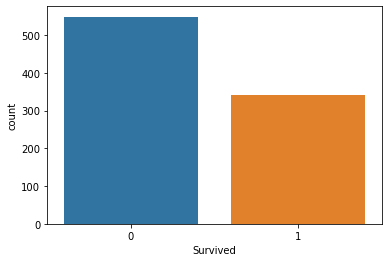

In [9]:
# Target
sb.countplot(x = df.Survived)

In [10]:
df_test.isnull().sum()

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64

`Age` and `Cabin` are missing data in both training and test sets. Missing values in `Cabin` are way higher, might be a good idea to drop the whole column.

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

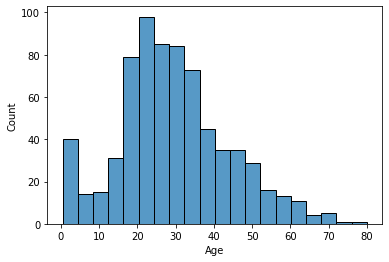

In [11]:
# How is Age distributed?

sb.histplot(x = df['Age'])

df['Age'].describe()


The `Age` is skewed to the right. While looking for a better way to replace missing values (e.g. based on some grouping factor, or KNN), we'll use the median as replacement.   
Also something noticeable is that the mininum age is 0.42 (probably because they are converting months to years).

In [12]:
df.Age.value_counts()

24.00    30
22.00    27
18.00    26
19.00    25
28.00    25
         ..
36.50     1
55.50     1
0.92      1
23.50     1
74.00     1
Name: Age, Length: 88, dtype: int64

# Exercise 1 (2pts):
Extract the title (Mr, Mrs, ... ) from the "Name" column.

Tips:
- split(',')[1] to get the 2nd part, and remove the surnamename
- split('.')[0] to get the 1str part, and remove the name

In [13]:
# CODE HERE get_Title_from_Name funtion
# Create this function using lambda (not def)

get_Title_from_Name = lambda x: x.split(',')[1].split('.')[0].strip()

df['Title'] = df['Name'].apply(get_Title_from_Name)
df_test['Title'] = df_test['Name'].apply(get_Title_from_Name)

In [14]:
df.Title.value_counts(), df_test.Title.value_counts()

(Mr              517
 Miss            182
 Mrs             125
 Master           40
 Dr                7
 Rev               6
 Mlle              2
 Major             2
 Col               2
 the Countess      1
 Capt              1
 Ms                1
 Sir               1
 Lady              1
 Mme               1
 Don               1
 Jonkheer          1
 Name: Title, dtype: int64,
 Mr        240
 Miss       78
 Mrs        72
 Master     21
 Col         2
 Rev         2
 Ms          1
 Dr          1
 Dona        1
 Name: Title, dtype: int64)

In [15]:
assert df['Title'].values[0] == "Mr"
assert df['Title'].values[1] == "Mrs"
assert df['Title'].values[2] == "Miss"

assert df_test['Title'].values[0] == "Mr"
assert df_test['Title'].values[1] == "Mrs"
assert df_test['Title'].values[414] == "Dona"

# Exercise 2 (1pts):
Apply the title_dictionary to get a better information about the title. You have to overwrite the Title variable.

In [16]:
title_dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}

In [17]:
# Use map to apply the prevous dict

df['Title'] = df['Title'].map(title_dictionary) 
df_test["Title"] = df_test['Title'].map(title_dictionary) 



In [18]:
assert df['Title'].values[886] == "Officer"
assert df_test['Title'].values[417] == "Master"

# Exercise OPTIONAL (0pts):
Try to extract some information from the feature **Ticket**. Search on Internet if that colum has some kind of information.

# Exercise OPTIONAL (0pts):
Try to extract some information from the feature **Cabin**. Search on Internet if that colum has some kind of information.

# Preprocessing
For X data, notice that...
- We drop Survived because is the target variable
- We drop Name because we have extracted the Title: Mr, Mrs, ...
- We drop Ticket because it has no information -> see df.Ticket.nunique()
- We drop Cabin because it has a lot of missings (77% are missings)

Then, we identify **numerical** variables and **categorical** variables,

In [19]:
x = df.drop(columns=["Survived", 'Name', 'Ticket', 'Cabin']) # X DATA (WILL BE TRAIN+VALID DATA)
y = df["Survived"] # 0 = No, 1 = Yes

x_test = df_test.drop(columns=['Name', 'Ticket', 'Cabin']) # # X_TEST DATA (NEW DATA)

In [20]:
print(x.shape, y.shape, x_test.shape)

(891, 8) (891,) (418, 8)


In [21]:
cat_vars  = ['Sex', 'Embarked', 'Title']         # x.select_dtypes(include=[object]).columns.values.tolist()
num_vars  = ['Pclass', 'SibSp', 'Parch', 'Fare', 'Age'] # x.select_dtypes(exclude=[object]).columns.values.tolist()

print("\nNumerical features:\n", num_vars)
print("\nCategorical features:\n", cat_vars)


Numerical features:
 ['Pclass', 'SibSp', 'Parch', 'Fare', 'Age']

Categorical features:
 ['Sex', 'Embarked', 'Title']


# Exercise 3 (2pts):
Create a **ColumnTransformer for Tree Models**. You need to create 2 pipelines (one for numerical and other for categories). Remember:
- Categorical pipeline: Some SimpleImputer -> Some Encoder
- Numerical pipeline: Some SimpleImputer -> NO Encoder

In [22]:
"""
num_preprocessing = pipeline.Pipeline(steps=[
  # Some SimpleImputer here
])

cat_preporcessing = pipeline.Pipeline(steps=[
  # Some SimpleImputer here
  # Some Encoder here. Remember to handle_unknown
])

tree_prepro = compose.ColumnTransformer(transformers=[
    ('num', num_preprocessing, num_vars),
    ('cat', cat_preporcessing, cat_vars),
], remainder='drop') # Drop other vars not specified in num_vars or cat_vars

tree_prepro
""";

### BEGIN SOLUTION


In [23]:
num_4_treeModels = pipeline.Pipeline(steps=[
  ('imputer', SimpleImputer(strategy='mean'))
])

cat_4_treeModels = pipeline.Pipeline(steps=[
  ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
  ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])
tree_prepro = compose.ColumnTransformer(transformers=[
    ('num', num_4_treeModels, num_vars),
    ('cat', cat_4_treeModels, cat_vars),
], remainder='drop') # Drop other vars not specified in num_vars or cat_vars

tree_prepro

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer())]),
                                 ['Pclass', 'SibSp', 'Parch', 'Fare', 'Age']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('ordinal',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 ['Sex', 'Embarked', 'Title'])])

In [24]:
assert type(tree_prepro)      is compose._column_transformer.ColumnTransformer
assert type(num_4_treeModels) is pipeline.Pipeline
assert type(cat_4_treeModels) is pipeline.Pipeline
assert len(num_4_treeModels) == 1
assert len(cat_4_treeModels) == 2

# Exercise 4 (1pts):
1. Complete the diccionary with some Tree Models.
2. Then we put each model in a Pipeline where:
   - first is the prepocessing with the column Transformer
   - Then is the Tree model
3. Display the fullpipeline of the LGBMClassifier

In [25]:
from sklearn.tree          import DecisionTreeClassifier
from sklearn.ensemble      import RandomForestClassifier
from sklearn.ensemble      import ExtraTreesClassifier
from sklearn.ensemble      import AdaBoostClassifier
from sklearn.ensemble      import GradientBoostingClassifier
# from sklearn.experimental  import enable_hist_gradient_boosting # Necesary for HistGradientBoostingClassifier
from sklearn.ensemble      import HistGradientBoostingClassifier
from xgboost               import XGBClassifier
from lightgbm              import LGBMClassifier
from catboost              import CatBoostClassifier

C:\Users\ADMIN\anaconda3\envs\strive\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [26]:
# n_estimators = 100
tree_classifiers = {
  "Decision Tree": DecisionTreeClassifier(random_state=0),
  "Extra Trees": ExtraTreesClassifier(random_state=0),
  "Random Forest":RandomForestClassifier(random_state=0),
  "AdaBoost": AdaBoostClassifier(random_state=0),
  "Skl GBM": GradientBoostingClassifier(random_state=0),
  "Skl HistGBM": HistGradientBoostingClassifier(random_state=0),
  "XGBoost": XGBClassifier(),
  "LightGBM": LGBMClassifier(random_state=0),
  "CatBoost": CatBoostClassifier(random_state=0)}


tree_classifiers = {name: pipeline.make_pipeline(tree_prepro, model) for name, model in tree_classifiers.items()}
tree_classifiers["LightGBM"]

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['Pclass', 'SibSp', 'Parch',
                                                   'Fare', 'Age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['Sex', 'Embarked',
                                                   'Title'])])),
                ('lgbmclassifier', LGBMClassifier(random_state=0))])

In [ ]:
for pipe in tree_classifiers.values():
    assert type(pipe) is pipeline.Pipeline

# Exercise 5 (3pts):
Define a simple split validation strategy with:
- 80% for train
- 20% for validation
- With stratification
- random_state=0

And train all the models in a for loop

In [27]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, stratify=y, random_state=0)
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(712, 8) (712,) (179, 8) (179,)


In [28]:
results = pd.DataFrame({'Model': [], 'Accuracy': [], 'Bal Acc.': [], 'Time': []})

for model_name, model in tree_classifiers.items():
    start_time = time.time()
    
    # Training
    model.fit(x_train, y_train)
    
    # GET PREDICTIONS USING x_val
    pred = model.predict(x_val)

    total_time = time.time() - start_time # Time taken to fit on train and predict on validation sets

    results = results.append({"Model":    model_name,
                              "Accuracy": metrics.accuracy_score(y_val, pred)*100,
                              "Bal Acc.": metrics.balanced_accuracy_score(y_val, pred)*100,
                              "Time":     total_time},
                              ignore_index=True)
                              
                              

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6560\3847013463.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model":    model_name,
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6560\3847013463.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model":    model_name,
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6560\3847013463.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model":    model_name,
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6560\3847013463.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model":    mode

[19:00:13] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6560\3847013463.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model":    model_name,
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6560\3847013463.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model":    model_name,


Learning rate set to 0.008911
0:	learn: 0.6896726	total: 144ms	remaining: 2m 24s
1:	learn: 0.6840036	total: 147ms	remaining: 1m 13s
2:	learn: 0.6784911	total: 149ms	remaining: 49.6s
3:	learn: 0.6726585	total: 151ms	remaining: 37.7s
4:	learn: 0.6659867	total: 153ms	remaining: 30.5s
5:	learn: 0.6602370	total: 158ms	remaining: 26.1s
6:	learn: 0.6544571	total: 160ms	remaining: 22.6s
7:	learn: 0.6500395	total: 161ms	remaining: 19.9s
8:	learn: 0.6447847	total: 163ms	remaining: 17.9s
9:	learn: 0.6418760	total: 164ms	remaining: 16.3s
10:	learn: 0.6367787	total: 166ms	remaining: 14.9s
11:	learn: 0.6315598	total: 168ms	remaining: 13.8s
12:	learn: 0.6262804	total: 170ms	remaining: 12.9s
13:	learn: 0.6206929	total: 174ms	remaining: 12.2s
14:	learn: 0.6163623	total: 176ms	remaining: 11.5s
15:	learn: 0.6119482	total: 178ms	remaining: 10.9s
16:	learn: 0.6079552	total: 179ms	remaining: 10.4s
17:	learn: 0.6032971	total: 181ms	remaining: 9.89s
18:	learn: 0.5987748	total: 183ms	remaining: 9.44s
19:	learn

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6560\3847013463.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Model":    model_name,


In [29]:
results_ord = results.sort_values(by=['Accuracy'], ascending=False, ignore_index=True)
results_ord.index += 1 
results_ord.style.bar(subset=['Accuracy', 'Bal Acc.'], vmin=0, vmax=100, color='#5fba7d')

,Model,Accuracy,Bal Acc.,Time
1,Skl GBM,84.916201,82.595520,0.170998
2,XGBoost,81.564246,78.787879,0.241998
3,Skl HistGBM,81.005587,78.603426,1.007999
4,LightGBM,81.005587,78.333333,0.203978
5,AdaBoost,79.888268,77.964427,0.134998
6,CatBoost,79.329609,76.969697,2.811433
7,Random Forest,78.212291,75.520422,0.359985
8,Decision Tree,77.094972,75.421607,0.032998
9,Extra Trees,76.536313,73.886693,0.275050


In [ ]:
"""
x_train, x_val, y_train, y_val = model_selection.train_test_split(
    # CODE HERE
)
"""

results = pd.DataFrame({'Model': [], 'Accuracy': [], 'Bal Acc.': [], 'Time': []})

"""
for model_name, model in tree_classifiers.items():
    start_time = time.time()
    
    # FOR EVERY PIPELINE (PREPRO + MODEL) -> TRAIN WITH TRAIN DATA (x_train)
    
    # GET PREDICTIONS USING x_val
    pred = # CODE HERE

    total_time = time.time() - start_time

    results = results.append({"Model":    model_name,
                              "Accuracy": metrics.accuracy_score(y_val, pred)*100,
                              "Bal Acc.": metrics.balanced_accuracy_score(y_val, pred)*100,
                              "Time":     total_time},
                              ignore_index=True)
                              
                              
"""

### BEGIN SOLUTION




results_ord = results.sort_values(by=['Accuracy'], ascending=False, ignore_index=True)
results_ord.index += 1 
results_ord.style.bar(subset=['Accuracy', 'Bal Acc.'], vmin=0, vmax=100, color='#5fba7d')

In [ ]:
assert results_ord["Accuracy"].min() > 75
assert results_ord["Bal Acc."].min() > 75
assert len(results_ord) == 9

# Exercise 6 (3pts):
Define a 10 Fold cross validation strategy with:
- With stratification
- shuffle=True
- random_state=0

And train all the models in a for loop.

Tip you can use **[cross_val_predict](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html)** for both training and predict with 

In [ ]:
skf = StratifiedKFold(10, shuffle=True, random_state=0)

results = pd.DataFrame({'Model': [], 'Accuracy': [], 'Bal Acc.': [], 'Time': []})


for model_name, model in tree_classifiers.items():
    start_time = time.time()
        
    # TRAIN AND GET PREDICTIONS USING cross_val_predict() and x,y
    pred = cross_val_predict(model, x_train, y_train, cv = skf)

    total_time = time.time() - start_time

    results = results.append({"Model":    model_name,
                              "Accuracy": metrics.accuracy_score(y_val, pred)*100,
                              "Bal Acc.": metrics.balanced_accuracy_score(y_val, pred)*100,
                              "Time":     total_time},
                              ignore_index=True)

results_ord = results.sort_values(by=['Accuracy'], ascending=False, ignore_index=True)
results_ord.index += 1 
results_ord.style.bar(subset=['Accuracy', 'Bal Acc.'], vmin=0, vmax=100, color='#5fba7d')

In [ ]:
"""
skf = model_selection.StratifiedKFold(
    # CODE HERE
)
"""



results = pd.DataFrame({'Model': [], 'Accuracy': [], 'Bal Acc.': [], 'Time': []})

"""
for model_name, model in tree_classifiers.items():
    start_time = time.time()
        
    # TRAIN AND GET PREDICTIONS USING cross_val_predict() and x,y
    pred = # CODE HERE

    total_time = time.time() - start_time

    results = results.append({"Model":    model_name,
                              "Accuracy": metrics.accuracy_score(y_val, pred)*100,
                              "Bal Acc.": metrics.balanced_accuracy_score(y_val, pred)*100,
                              "Time":     total_time},
                              ignore_index=True)
                              
                              
"""


results_ord = results.sort_values(by=['Accuracy'], ascending=False, ignore_index=True)
results_ord.index += 1 
results_ord.style.bar(subset=['Accuracy', 'Bal Acc.'], vmin=0, vmax=100, color='#5fba7d')

In [ ]:
assert results_ord["Accuracy"].min() > 75
assert results_ord["Bal Acc."].min() > 75
assert len(results_ord) == 9

# Exercise 7.1
Train with all data the best model

In [ ]:
best_model = tree_classifiers["Skl GBM"]

# Fit best model with all data
best_model.fit(x, y)

# Exercise 7.2 (2pts)
With your best model, generate the predicitions for test data (x_test)

In [ ]:
# test_pred = # Get the predictions for x_test
test_pred = best_model.predict(x_test)



In [ ]:
assert len(test_pred) == 418
assert np.unique(test_pred).tolist() == [0,1]

# Exercise 7.3

Submit to kaggle.

- You can use the kaggle command line app. Check https://github.com/Kaggle/kaggle-api

In [ ]:
"""sub = pd.DataFrame(test_pred, index=x_test.index, columns=["Survived"])
sub.head()"""

In [ ]:
'''sub.to_csv("sub.csv")'''

In [ ]:
!kaggle competitions submit -c titanic -f sub.csv -m "My submission message"